In [22]:
import json
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical


In [23]:
#Extract Labels and colours

label_data = {
    "labels": [
        {"name": "animal--bird", "readable": "Bird", "instances": True, "evaluate": True, "color": [165, 42, 42]}, {"name": "animal--ground-animal", "readable": "Ground Animal", "instances": True, "evaluate": True, "color": [0, 192, 0]}, {"name": "construction--barrier--ambiguous", "readable": "Ambiguous Barrier", "instances": False, "evaluate": False, "color": [250, 170, 31]}, {"name": "construction--barrier--concrete-block", "readable": "Concrete Block", "instances": False, "evaluate": True, "color": [250, 170, 32]}, {"name": "construction--barrier--curb", "readable": "Curb", "instances": False, "evaluate": True, "color": [196, 196, 196]}, {"name": "construction--barrier--fence", "readable": "Fence", "instances": False, "evaluate": True, "color": [190, 153, 153]}, {"name": "construction--barrier--guard-rail", "readable": "Guard Rail", "instances": False, "evaluate": True, "color": [180, 165, 180]}, {"name": "construction--barrier--other-barrier", "readable": "Barrier", "instances": False, "evaluate": True, "color": [90, 120, 150]}, {"name": "construction--barrier--road-median", "readable": "Road Median", "instances": False, "evaluate": True, "color": [250, 170, 33]}, {"name": "construction--barrier--road-side", "readable": "Road Side", "instances": False, "evaluate": True, "color": [250, 170, 34]}, {"name": "construction--barrier--separator", "readable": "Lane Separator", "instances": False, "evaluate": True, "color": [128, 128, 128]}, {"name": "construction--barrier--temporary", "readable": "Temporary Barrier", "instances": True, "evaluate": True, "color": [250, 170, 35]}, {"name": "construction--barrier--wall", "readable": "Wall", "instances": False, "evaluate": True, "color": [102, 102, 156]}, {"name": "construction--flat--bike-lane", "readable": "Bike Lane", "instances": False, "evaluate": True, "color": [128, 64, 255]}, {"name": "construction--flat--crosswalk-plain", "readable": "Crosswalk - Plain", "instances": True, "evaluate": True, "color": [140, 140, 200]}, {"name": "construction--flat--curb-cut", "readable": "Curb Cut", "instances": False, "evaluate": True, "color": [170, 170, 170]}, {"name": "construction--flat--driveway", "readable": "Driveway", "instances": True, "evaluate": True, "color": [250, 170, 36]}, {"name": "construction--flat--parking", "readable": "Parking", "instances": False, "evaluate": True, "color": [250, 170, 160]}, {"name": "construction--flat--parking-aisle", "readable": "Parking Aisle", "instances": False, "evaluate": True, "color": [250, 170, 37]}, {"name": "construction--flat--pedestrian-area", "readable": "Pedestrian Area", "instances": False, "evaluate": True, "color": [96, 96, 96]}, {"name": "construction--flat--rail-track", "readable": "Rail Track", "instances": False, "evaluate": True, "color": [230, 150, 140]}, {"name": "construction--flat--road", "readable": "Road", "instances": False, "evaluate": True, "color": [128, 64, 128]}, {"name": "construction--flat--road-shoulder", "readable": "Road Shoulder", "instances": False, "evaluate": True, "color": [110, 110, 110]}, {"name": "construction--flat--service-lane", "readable": "Service Lane", "instances": False, "evaluate": True, "color": [110, 110, 110]}, {"name": "construction--flat--sidewalk", "readable": "Sidewalk", "instances": False, "evaluate": True, "color": [244, 35, 232]}, {"name": "construction--flat--traffic-island", "readable": "Traffic Island", "instances": False, "evaluate": True, "color": [128, 196, 128]}, {"name": "construction--structure--bridge", "readable": "Bridge", "instances": False, "evaluate": True, "color": [150, 100, 100]}, {"name": "construction--structure--building", "readable": "Building", "instances": False, "evaluate": True, "color": [70, 70, 70]}, {"name": "construction--structure--garage", "readable": "Garage", "instances": False, "evaluate": True, "color": [150, 150, 150]}, {"name": "construction--structure--tunnel", "readable": "Tunnel", "instances": False, "evaluate": True, "color": [150, 120, 90]}, {"name": "human--person--individual", "readable": "Person", "instances": True, "evaluate": True, "color": [220, 20, 60]}, {"name": "human--person--person-group", "readable": "Person Group", "instances": False, "evaluate": False, "color": [220, 20, 60]}, {"name": "human--rider--bicyclist", "readable": "Bicyclist", "instances": True, "evaluate": True, "color": [255, 0, 0]}, {"name": "human--rider--motorcyclist", "readable": "Motorcyclist", "instances": True, "evaluate": True, "color": [255, 0, 100]}, {"name": "human--rider--other-rider", "readable": "Other Rider", "instances": True, "evaluate": True, "color": [255, 0, 200]}, {"name": "marking--continuous--dashed", "readable": "Lane Marking - Dashed Line", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking--continuous--solid", "readable": "Lane Marking - Straight Line", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking--continuous--zigzag", "readable": "Lane Marking - Zigzag Line", "instances": False, "evaluate": True, "color": [250, 170, 29]}, {"name": "marking--discrete--ambiguous", "readable": "Lane Marking - Ambiguous", "instances": False, "evaluate": False, "color": [250, 170, 28]}, {"name": "marking--discrete--arrow--left", "readable": "Lane Marking - Arrow (Left)", "instances": True, "evaluate": True, "color": [250, 170, 26]}, {"name": "marking--discrete--arrow--other", "readable": "Lane Marking - Arrow (Other)", "instances": True, "evaluate": True, "color": [250, 170, 25]}, {"name": "marking--discrete--arrow--right", "readable": "Lane Marking - Arrow (Right)", "instances": True, "evaluate": True, "color": [250, 170, 24]}, {"name": "marking--discrete--arrow--split-left-or-straight", "readable": "Lane Marking - Arrow (Split Left or Straight)", "instances": True, "evaluate": True, "color": [250, 170, 22]}, {"name": "marking--discrete--arrow--split-right-or-straight", "readable": "Lane Marking - Arrow (Split Right or Straight)", "instances": True, "evaluate": True, "color": [250, 170, 21]}, {"name": "marking--discrete--arrow--straight", "readable": "Lane Marking - Arrow (Straight)", "instances": True, "evaluate": True, "color": [250, 170, 20]}, {"name": "marking--discrete--crosswalk-zebra", "readable": "Lane Marking - Crosswalk", "instances": True, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking--discrete--give-way-row", "readable": "Lane Marking - Give Way (Row)", "instances": True, "evaluate": True, "color": [250, 170, 19]}, {"name": "marking--discrete--give-way-single", "readable": "Lane Marking - Give Way (Single)", "instances": True, "evaluate": True, "color": [250, 170, 18]}, {"name": "marking--discrete--hatched--chevron", "readable": "Lane Marking - Hatched (Chevron)", "instances": False, "evaluate": True, "color": [250, 170, 12]}, {"name": "marking--discrete--hatched--diagonal", "readable": "Lane Marking - Hatched (Diagonal)", "instances": False, "evaluate": True, "color": [250, 170, 11]}, {"name": "marking--discrete--other-marking", "readable": "Lane Marking - Other", "instances": True, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking--discrete--stop-line", "readable": "Lane Marking - Stop Line", "instances": True, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking--discrete--symbol--bicycle", "readable": "Lane Marking - Symbol (Bicycle)", "instances": True, "evaluate": True, "color": [250, 170, 16]}, {"name": "marking--discrete--symbol--other", "readable": "Lane Marking - Symbol (Other)", "instances": True, "evaluate": True, "color": [250, 170, 15]}, {"name": "marking--discrete--text", "readable": "Lane Marking - Text", "instances": True, "evaluate": True, "color": [250, 170, 15]}, {"name": "marking-only--continuous--dashed", "readable": "Lane Marking (only) - Dashed Line", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking-only--discrete--crosswalk-zebra", "readable": "Lane Marking (only) - Crosswalk", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking-only--discrete--other-marking", "readable": "Lane Marking (only) - Other", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "marking-only--discrete--text", "readable": "Lane Marking (only) - Test", "instances": False, "evaluate": True, "color": [255, 255, 255]}, {"name": "nature--mountain", "readable": "Mountain", "instances": False, "evaluate": True, "color": [64, 170, 64]}, {"name": "nature--sand", "readable": "Sand", "instances": False, "evaluate": True, "color": [230, 160, 50]}, {"name": "nature--sky", "readable": "Sky", "instances": False, "evaluate": True, "color": [70, 130, 180]}, {"name": "nature--snow", "readable": "Snow", "instances": False, "evaluate": True, "color": [190, 255, 255]}, {"name": "nature--terrain", "readable": "Terrain", "instances": False, "evaluate": True, "color": [152, 251, 152]}, {"name": "nature--vegetation", "readable": "Vegetation", "instances": False, "evaluate": True, "color": [107, 142, 35]}, {"name": "nature--water", "readable": "Water", "instances": False, "evaluate": True, "color": [0, 170, 30]}, {"name": "object--banner", "readable": "Banner", "instances": True, "evaluate": True, "color": [255, 255, 128]}, {"name": "object--bench", "readable": "Bench", "instances": True, "evaluate": True, "color": [250, 0, 30]}, {"name": "object--bike-rack", "readable": "Bike Rack", "instances": True, "evaluate": True, "color": [100, 140, 180]}, {"name": "object--catch-basin", "readable": "Catch Basin", "instances": True, "evaluate": True, "color": [220, 128, 128]}, {"name": "object--cctv-camera", "readable": "CCTV Camera", "instances": True, "evaluate": True, "color": [222, 40, 40]}, {"name": "object--fire-hydrant", "readable": "Fire Hydrant", "instances": True, "evaluate": True, "color": [100, 170, 30]}, {"name": "object--junction-box", "readable": "Junction Box", "instances": True, "evaluate": True, "color": [40, 40, 40]}, {"name": "object--mailbox", "readable": "Mailbox", "instances": True, "evaluate": True, "color": [33, 33, 33]}, {"name": "object--manhole", "readable": "Manhole", "instances": True, "evaluate": True, "color": [100, 128, 160]}, {"name": "object--parking-meter", "readable": "Parking Meter", "instances": True, "evaluate": True, "color": [20, 20, 255]}, {"name": "object--phone-booth", "readable": "Phone Booth", "instances": True, "evaluate": True, "color": [142, 0, 0]}, {"name": "object--pothole", "readable": "Pothole", "instances": False, "evaluate": True, "color": [70, 100, 150]}, {"name": "object--sign--advertisement", "readable": "Signage - Advertisement", "instances": True, "evaluate": True, "color": [250, 171, 30]}, {"name": "object--sign--ambiguous", "readable": "Signage - Ambiguous", "instances": True, "evaluate": False, "color": [250, 172, 30]}, {"name": "object--sign--back", "readable": "Signage - Back", "instances": True, "evaluate": True, "color": [250, 173, 30]}, {"name": "object--sign--information", "readable": "Signage - Information", "instances": True, "evaluate": True, "color": [250, 174, 30]}, {"name": "object--sign--other", "readable": "Signage - Other", "instances": True, "evaluate": True, "color": [250, 175, 30]}, {"name": "object--sign--store", "readable": "Signage - Store", "instances": True, "evaluate": True, "color": [250, 176, 30]}, {"name": "object--street-light", "readable": "Street Light", "instances": True, "evaluate": True, "color": [210, 170, 100]}, {"name": "object--support--pole", "readable": "Pole", "instances": True, "evaluate": True, "color": [153, 153, 153]}, {"name": "object--support--pole-group", "readable": "Pole Group", "instances": False, "evaluate": False, "color": [153, 153, 153]}, {"name": "object--support--traffic-sign-frame", "readable": "Traffic Sign Frame", "instances": True, "evaluate": True, "color": [128, 128, 128]}, {"name": "object--support--utility-pole", "readable": "Utility Pole", "instances": True, "evaluate": True, "color": [0, 0, 80]}, {"name": "object--traffic-cone", "readable": "Traffic Cone", "instances": True, "evaluate": True, "color": [210, 60, 60]}, {"name": "object--traffic-light--general-single", "readable": "Traffic Light - General (Single)", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-light--pedestrians", "readable": "Traffic Light - Pedestrians", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-light--general-upright", "readable": "Traffic Light - General (Upright)", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-light--general-horizontal", "readable": "Traffic Light - General (Horizontal)", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-light--cyclists", "readable": "Traffic Light - Cyclists", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-light--other", "readable": "Traffic Light - Other", "instances": True, "evaluate": True, "color": [250, 170, 30]}, {"name": "object--traffic-sign--ambiguous", "readable": "Traffic Sign - Ambiguous", "instances": True, "evaluate": False, "color": [192, 192, 192]}, {"name": "object--traffic-sign--back", "readable": "Traffic Sign (Back)", "instances": True, "evaluate": True, "color": [192, 192, 192]}, {"name": "object--traffic-sign--direction-back", "readable": "Traffic Sign - Direction (Back)", "instances": True, "evaluate": True, "color": [192, 192, 192]}, {"name": "object--traffic-sign--direction-front", "readable": "Traffic Sign - Direction (Front)", "instances": True, "evaluate": True, "color": [220, 220, 0]}, {"name": "object--traffic-sign--front", "readable": "Traffic Sign (Front)", "instances": True, "evaluate": True, "color": [220, 220, 0]}, {"name": "object--traffic-sign--information-parking", "readable": "Traffic Sign - Parking", "instances": True, "evaluate": True, "color": [0, 0, 196]}, {"name": "object--traffic-sign--temporary-back", "readable": "Traffic Sign - Temporary (Back)", "instances": True, "evaluate": True, "color": [192, 192, 192]}, {"name": "object--traffic-sign--temporary-front", "readable": "Traffic Sign - Temporary (Front)", "instances": True, "evaluate": True, "color": [220, 220, 0]}, {"name": "object--trash-can", "readable": "Trash Can", "instances": True, "evaluate": True, "color": [140, 140, 20]}, {"name": "object--vehicle--bicycle", "readable": "Bicycle", "instances": True, "evaluate": True, "color": [119, 11, 32]}, {"name": "object--vehicle--boat", "readable": "Boat", "instances": True, "evaluate": True, "color": [150, 0, 255]}, {"name": "object--vehicle--bus", "readable": "Bus", "instances": True, "evaluate": True, "color": [0, 60, 100]}, {"name": "object--vehicle--car", "readable": "Car", "instances": True, "evaluate": True, "color": [0, 0, 142]}, {"name": "object--vehicle--caravan", "readable": "Caravan", "instances": True, "evaluate": True, "color": [0, 0, 90]}, {"name": "object--vehicle--motorcycle", "readable": "Motorcycle", "instances": True, "evaluate": True, "color": [0, 0, 230]}, {"name": "object--vehicle--on-rails", "readable": "On Rails", "instances": True, "evaluate": True, "color": [0, 80, 100]}, {"name": "object--vehicle--other-vehicle", "readable": "Other Vehicle", "instances": True, "evaluate": True, "color": [128, 64, 64]}, {"name": "object--vehicle--trailer", "readable": "Trailer", "instances": True, "evaluate": True, "color": [0, 0, 110]}, {"name": "object--vehicle--truck", "readable": "Truck", "instances": True, "evaluate": True, "color": [0, 0, 70]}, {"name": "object--vehicle--vehicle-group", "readable": "Vehicle Group", "instances": False, "evaluate": False, "color": [0, 0, 142]}, {"name": "object--vehicle--wheeled-slow", "readable": "Wheeled Slow", "instances": True, "evaluate": True, "color": [0, 0, 192]}, {"name": "object--water-valve", "readable": "Water Valve", "instances": True, "evaluate": True, "color": [170, 170, 170]}, {"name": "void--car-mount", "readable": "Car Mount", "instances": False, "evaluate": True, "color": [32, 32, 32]}, {"name": "void--dynamic", "readable": "Dynamic", "instances": False, "evaluate": True, "color": [111, 74, 0]}, {"name": "void--ego-vehicle", "readable": "Ego Vehicle", "instances": False, "evaluate": True, "color": [120, 10, 10]}, {"name": "void--ground", "readable": "Ground", "instances": False, "evaluate": True, "color": [81, 0, 81]}, {"name": "void--static", "readable": "Static", "instances": False, "evaluate": True, "color": [111, 111, 0]}, {"name": "void--unlabeled", "readable": "Unlabeled", "instances": False, "evaluate": False, "color": [0, 0, 0]}
    ]
}
names_dict = {}
class_colors = {}

# Iteramos sobre las etiquetas y agregamos los datos a los diccionarios correspondientes
for i, label in enumerate(label_data["labels"]):
    name = label["readable"]
    rgb_code = label["color"]
    names_dict[i] = name
    class_colors[i] = rgb_code

print("Diccionario de nombres de clases:")
print(names_dict)
print("\nDiccionario de códigos RGB:")
print(class_colors)

Diccionario de nombres de clases:
{0: 'Bird', 1: 'Ground Animal', 2: 'Ambiguous Barrier', 3: 'Concrete Block', 4: 'Curb', 5: 'Fence', 6: 'Guard Rail', 7: 'Barrier', 8: 'Road Median', 9: 'Road Side', 10: 'Lane Separator', 11: 'Temporary Barrier', 12: 'Wall', 13: 'Bike Lane', 14: 'Crosswalk - Plain', 15: 'Curb Cut', 16: 'Driveway', 17: 'Parking', 18: 'Parking Aisle', 19: 'Pedestrian Area', 20: 'Rail Track', 21: 'Road', 22: 'Road Shoulder', 23: 'Service Lane', 24: 'Sidewalk', 25: 'Traffic Island', 26: 'Bridge', 27: 'Building', 28: 'Garage', 29: 'Tunnel', 30: 'Person', 31: 'Person Group', 32: 'Bicyclist', 33: 'Motorcyclist', 34: 'Other Rider', 35: 'Lane Marking - Dashed Line', 36: 'Lane Marking - Straight Line', 37: 'Lane Marking - Zigzag Line', 38: 'Lane Marking - Ambiguous', 39: 'Lane Marking - Arrow (Left)', 40: 'Lane Marking - Arrow (Other)', 41: 'Lane Marking - Arrow (Right)', 42: 'Lane Marking - Arrow (Split Left or Straight)', 43: 'Lane Marking - Arrow (Split Right or Straight)', 44

In [24]:
def json_to_mask(json_file, image_shape):
    with open(json_file) as f:
        data = json.load(f)

    mask = np.zeros(image_shape[:2], dtype=np.uint8)  # Asegurarse de que la máscara tenga el mismo tamaño que la imagen (alto, ancho)

    if 'objects' not in data:
        print(f"No 'objects' key found in JSON: {json_file}")
        return mask

    for obj in data['objects']:
        class_id = obj.get('id', 1)  # Usar un valor por defecto si no se encuentra 'id'
        polygon = np.array(obj['polygon'], dtype=np.int32)
        
        if polygon.size == 0:
            print(f"Empty polygon in object {obj} in JSON: {json_file}")
            continue

        # Convertir coordenadas flotantes a enteras
        polygon = polygon.reshape((-1, 1, 2)).astype(np.int32)
        
        if not np.all((polygon[:, :, 0] >= 0) & (polygon[:, :, 0] < image_shape[1]) & 
                      (polygon[:, :, 1] >= 0) & (polygon[:, :, 1] < image_shape[0])):
            #print(f"Polygon out of bounds in JSON: {json_file}")
            continue
        
        # Dibujar el polígono en la máscara
        cv2.fillPoly(mask, [polygon], class_id)

    return mask

In [25]:
def show_mask(image, mask):
    """
    Muestra una imagen con su máscara superpuesta.

    Args:
        image (np.ndarray): Imagen original.
        mask (np.ndarray): Máscara de segmentación.
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    
    # Crear un mapa de colores para las clases
    unique_classes = np.unique(mask)
    cmap = plt.get_cmap('tab20', len(unique_classes))  # 'tab20' tiene 20 colores distintos

    # Superponer la máscara con colores para cada clase
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id in unique_classes:
        if class_id != 0:  # Ignorar fondo si es 0
            color = (np.array(cmap(class_id)[:3]) * 255).astype(np.uint8)
            mask_rgb[mask == class_id] = color

    plt.imshow(mask_rgb, alpha=0.5)  # Superponer la máscara con transparencia
    plt.title("Máscara de Segmentación")
    plt.axis('off')

    plt.show()

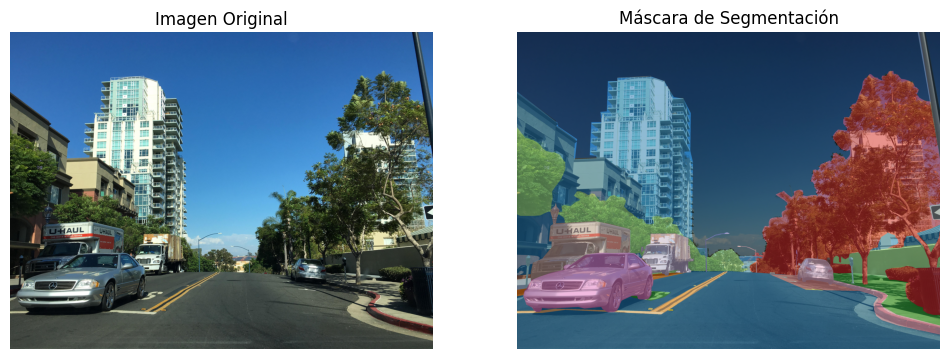

In [26]:
json_file = 'DS/polygons_sample/train/_4g6iIzKJPj_8_PTRPIV3Q.json'
image_file = 'DS/images_sample/train/_4g6iIzKJPj_8_PTRPIV3Q.jpg'

# Leer imagen
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

# Crear máscara y obtener colores de clases
image_shape= image.shape[:2]  # Altura y anchura de la imagen
mask = json_to_mask(json_file, image_shape)

# Mostrar imagen y máscara con leyenda
show_mask(image, mask)

In [27]:
image_directory = 'DS/images_sample/train'
json_directory = 'DS/polygons_sample/train'
num_classes= 124



In [28]:
def data_generator(image_dir, json_dir, batch_size=32, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json')])

    assert len(image_files) == len(json_files), "Mismatch between image and JSON files"

    num_files = len(image_files)
    while True:
        batch_images = []
        batch_masks = []

        for i in range(num_files):
            image_file = image_files[i]
            json_file = json_files[i]

            image_path = os.path.join(image_dir, image_file)
            json_path = os.path.join(json_dir, json_file)

            image = cv2.imread(image_path)
            if image is None:
                print(f"Error reading image: {image_path}")
                continue

            image_resized = cv2.resize(image, target_size)

            mask = json_to_mask(json_path, image.shape)
            mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            mask_resized = np.clip(mask_resized, 0, num_classes-1)

            batch_images.append(image_resized)
            batch_masks.append(mask_resized)

            if len(batch_images) >= batch_size:
                yield np.array(batch_images) / 255.0, np.array(batch_masks)
                batch_images, batch_masks = [], []

        # Manejar el último lote que no alcanza el batch_size
        if batch_images:
            yield np.array(batch_images) / 255.0, np.array(batch_masks)
            batch_images, batch_masks = [], []

In [29]:
generator = data_generator(image_directory, json_directory, batch_size=10, target_size=(256, 256))


In [30]:
images, masks = next(generator)
print("Shape of images:", images.shape)
print("Shape of masks:", masks.shape)

Shape of images: (10, 256, 256, 3)
Shape of masks: (10, 256, 256)


In [31]:
for i, mask in enumerate(masks):
    print(f"Unique values in mask {i}:", np.unique(mask))

Unique values in mask 0: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
Unique values in mask 1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 68 69 70]
Unique values in mask 2: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
Unique values in mask 3: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 67]
Unique values in mask 4: [  0   1   2   3   4   5   8   9  11  12  13  14  15  16  17  18  19  20
  21  25  26  28  29  31 

In [32]:
def visualize_images_and_masks(images, masks, num_samples=5):
    num_samples = min(num_samples, len(images))

    for i in range(num_samples):
        # Mostrar la imagen
        plt.subplot(num_samples, 2, 2*i + 1)
        image = images[i]
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)  # Convertir a uint8 si no lo es
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Imagen')
        plt.axis('off')

        # Mostrar la máscara
        plt.subplot(num_samples, 2, 2*i + 2)
        mask = masks[i]
        plt.imshow(mask, cmap='gray')  # Puedes cambiar el mapa de colores según necesites
        plt.title('Máscara')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

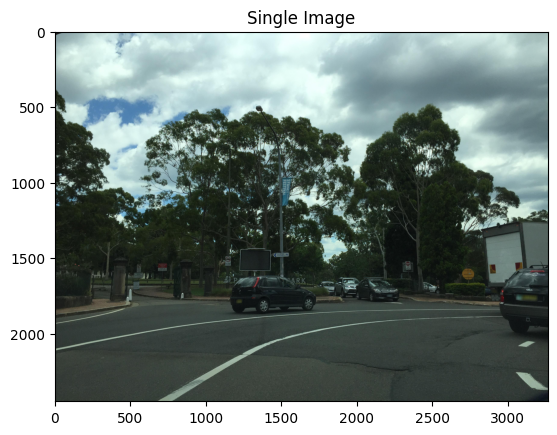

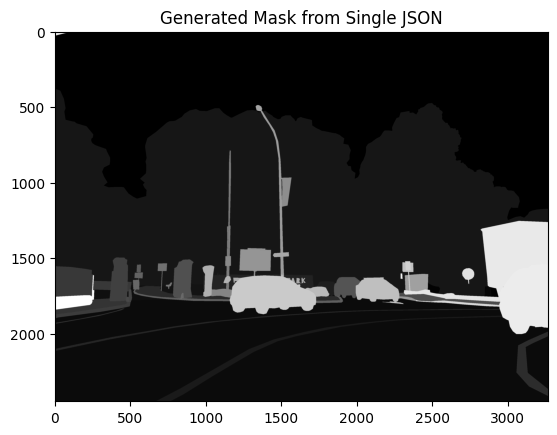

In [33]:
single_image_path = 'DS/images_sample/train/_9UM7qSvErpylsj24u9WYg.jpg'
single_json_path = 'DS/polygons_sample/train/_9UM7qSvErpylsj24u9WYg.json'

image = cv2.imread(single_image_path)
if image is None:
    print(f"Error reading single image: {single_image_path}")
else:
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Single Image')
    plt.show()

mask = json_to_mask(single_json_path, image.shape)
if mask is not None:
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title('Generated Mask from Single JSON')
    plt.show()

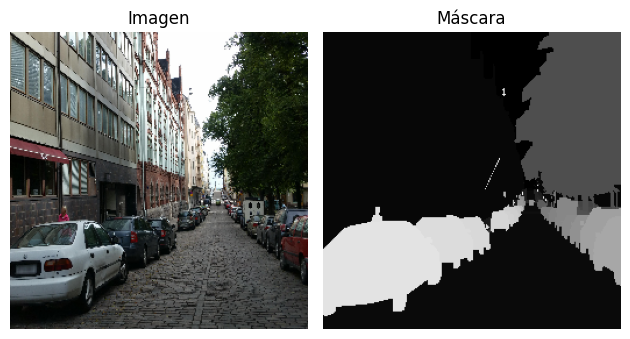

In [34]:
visualize_images_and_masks(images, masks, num_samples=1)

In [35]:
def unet(input_size=(256, 256, 3), num_classes=124):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Crear el modelo
model = unet(input_size=(256, 256, 3), num_classes=124)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,039,740 (118.41 MB)

 Trainable params: 31,039,740 (118.41 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [37]:
batch_size = 5
epochs = 50

# Generadores de datos





In [38]:
train_generator = data_generator(image_directory, json_directory, batch_size=batch_size, target_size=(256, 256))

In [39]:
# Callbacks
checkpoint = ModelCheckpoint('unet_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')

In [40]:
model.fit(
    train_generator,
    steps_per_epoch=len(os.listdir(image_directory)) // batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2256 - loss: 4.5801 
Epoch 1: loss improved from inf to 4.23783, saving model to unet_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 314s 15s/step - accuracy: 0.2288 - loss: 4.5638
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3116 - loss: 3.4136 
Epoch 2: loss improved from 4.23783 to 3.25331, saving model to unet_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 289s 14s/step - accuracy: 0.3123 - loss: 3.4060
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3116 - loss: 3.0994 
Epoch 3: loss improved from 3.25331 to 3.03578, saving model to unet_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 280s 14s/step - accuracy: 0.3123 - loss: 3.0964
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3116 - loss: 2.9663 
Epoch 4: loss improved from 3.03578 to 2.93215, saving model to unet_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 254s 13s/step - accuracy: 0.3123 - loss: 2.9646
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s

In [43]:
model.save('Sample_json_Masks_20_epochs.h5')

In [55]:
def visualize_predictions(model, generator, num_samples=3, target_size=(256, 256), num_classes=124):
    batch_images, batch_true_masks = next(generator)

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        image = batch_images[i]
        true_mask = batch_true_masks[i]

        # Predicción
        pred_mask_prob = model.predict(np.expand_dims(image, axis=0))[0]
        
        # Obtener la clase con la mayor probabilidad
        pred_mask = np.argmax(pred_mask_prob, axis=-1)

        # Mostrar imagen
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(image)
        plt.title('Imagen')
        plt.axis('off')

        # Mostrar máscara verdadera
        plt.subplot(num_samples, 3, 3*i + 2)
        if true_mask.ndim == 3 and true_mask.shape[-1] == num_classes:
            true_mask_rgb = np.argmax(true_mask, axis=-1)
        else:
            true_mask_rgb = true_mask
        plt.imshow(true_mask_rgb)
        plt.title('Máscara Verdadera')
        plt.axis('off')

        # Mostrar máscara predicha
        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_mask)
        plt.title('Máscara Predicha')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


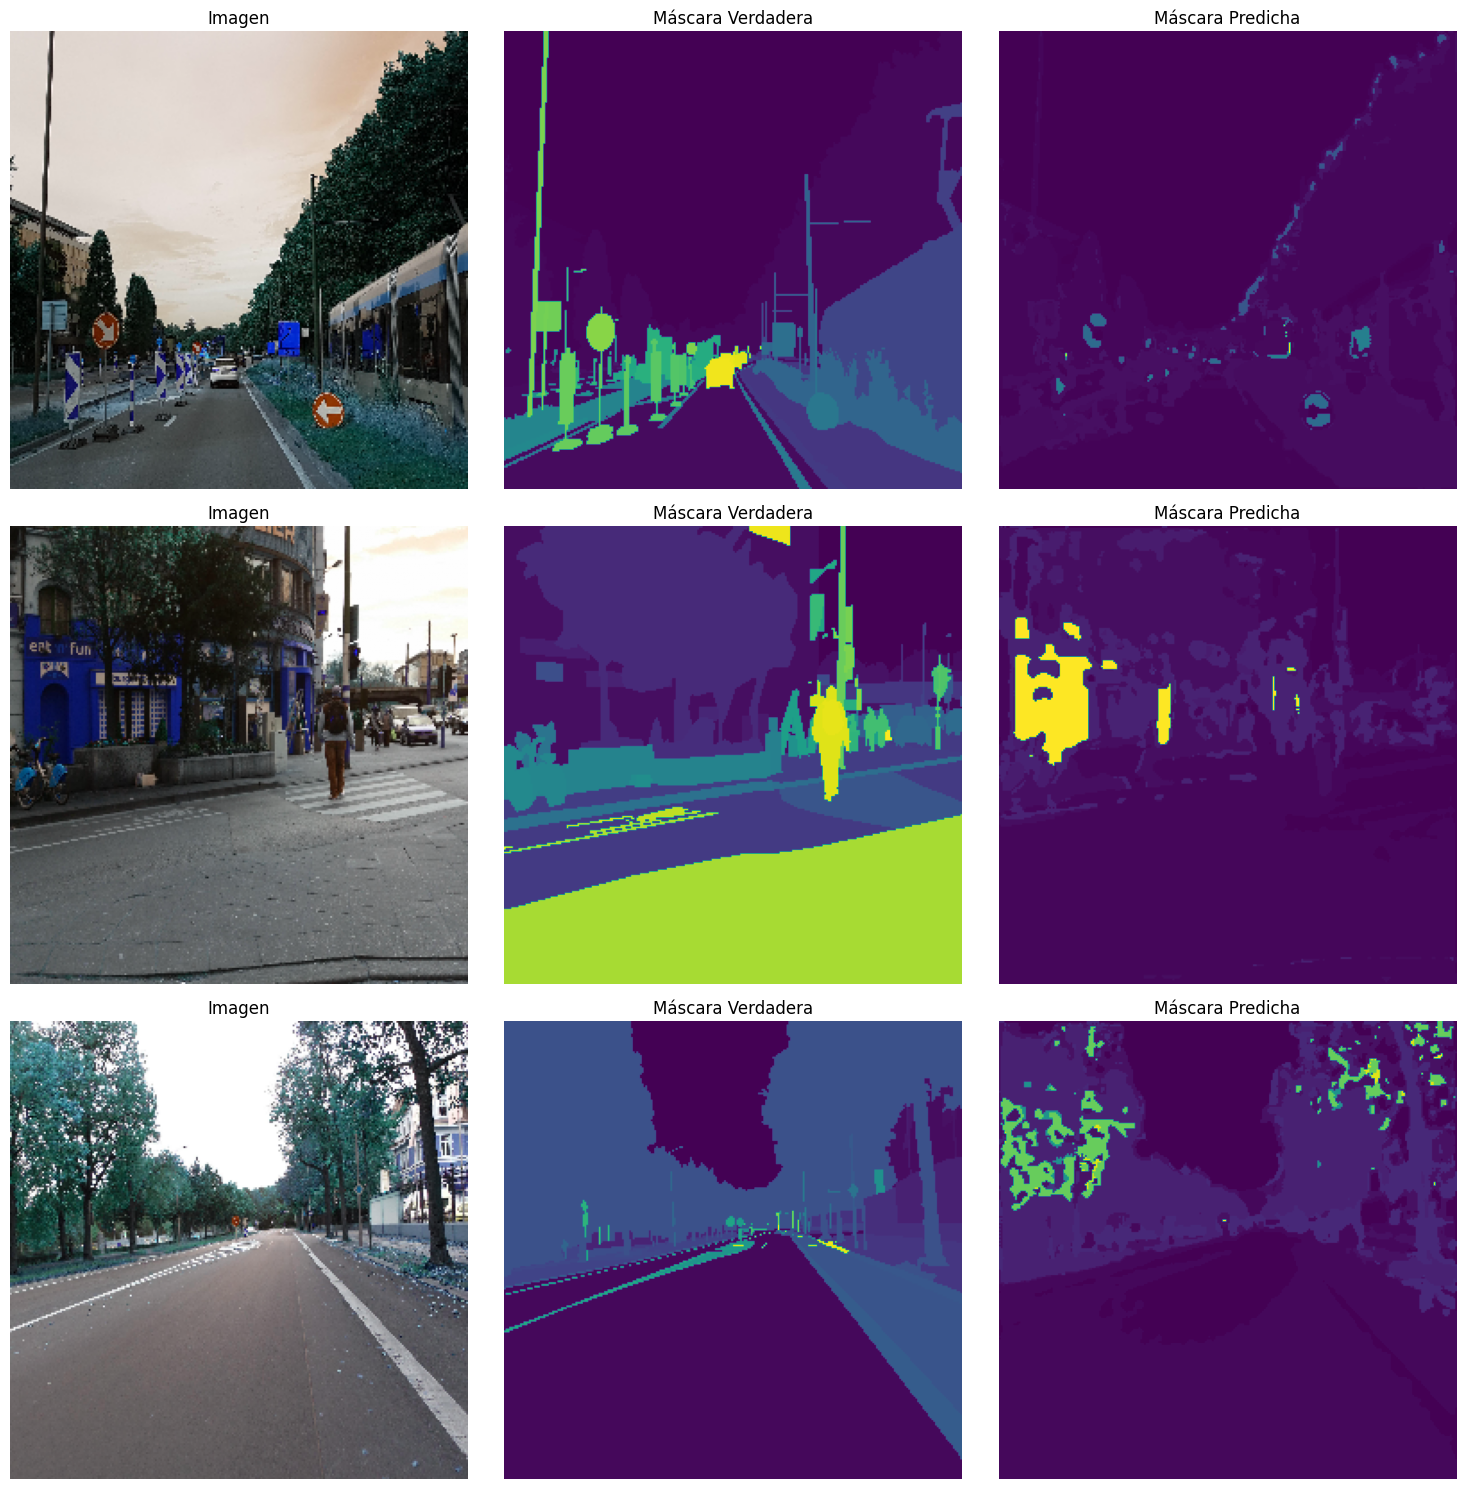

In [56]:
visualize_predictions(model, generator, num_samples=3, target_size=(256, 256), num_classes=124)